In [1]:
!pip install -q torch torchvision pillow numpy scikit-image matplotlib einops tqdm pytorch-msssim


Upload dataset and unzip it

In [2]:
from google.colab import files, drive
import zipfile, os, glob, shutil

uploaded = files.upload()  # pick dataset.zip in the browser dialog
zip_name = next(iter(uploaded.keys()))
print('Uploaded', zip_name)

Saving archive (19).zip to archive (19).zip
Uploaded archive (19).zip


In [3]:
dst = '/content/dataset'
if os.path.exists(dst):
    shutil.rmtree(dst)
os.makedirs(dst, exist_ok=True)

import zipfile
with zipfile.ZipFile(zip_name, 'r') as z:
    z.extractall(dst)

img_files = [f for f in glob.glob(dst + '/**/*', recursive=True)
             if f.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tif','.tiff'))]
print('Extracted image files:', len(img_files))

Extracted image files: 1360


Imports & config

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np, os, glob, random
from PIL import Image
import io
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

IMG_SIZE = 256
BATCH_SIZE = 16
LATENT_CHANNELS = 64
EPOCHS = 10
MAX_SAMPLES = None
TARGET_SSIM = 0.995
OUTPUT_DIR = '/content/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

AUTOTUNE = tf.data.experimental.AUTOTUNE
print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [5]:
import os, zipfile, shutil
EXTRACT_DIR = '/content/dataset'
if os.path.exists(EXTRACT_DIR):
    print("Dataset already extracted at", EXTRACT_DIR)
else:
    print("Extracting", DATA_ZIP_PATH, "->", EXTRACT_DIR)
    with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("Done.")

Dataset already extracted at /content/dataset


discover image files and a small sanity check

In [7]:
def find_images(root):
    exts = ('*.jpg','*.jpeg','*.png','*.bmp','*.tiff')
    files=[]
    for ext in exts:
        files += glob.glob(os.path.join(root, '**', ext), recursive=True)
    return sorted(files)

# try common places
cands = [EXTRACT_DIR, os.path.join(EXTRACT_DIR,'images'), os.path.join(EXTRACT_DIR,'Images')]
image_files = []
for c in cands:
    if os.path.exists(c):
        image_files = find_images(c)
        if image_files:
            break
# fallback: search entire extract dir
if not image_files:
    image_files = find_images(EXTRACT_DIR)
print("Found image count:", len(image_files))
if MAX_SAMPLES:
    image_files = image_files[:MAX_SAMPLES]
print("Using", len(image_files), "images for this run.")


Found image count: 1360
Using 1360 images for this run.


In [8]:
from PIL import Image
import pandas as pd
rows = []
for p in image_files:
    try:
        with Image.open(p) as im:
            w,h = im.size
        size_b = os.path.getsize(p)
        rows.append({'filename': os.path.basename(p), 'path': p, 'width': w, 'height': h, 'orig_size_bytes': size_b})
    except Exception as e:
        print("skip", p, e)
df_orig = pd.DataFrame(rows)
df_orig['orig_size_kb'] = df_orig['orig_size_bytes'] / 1024.0
print("Sample originals:")
display(df_orig.head(10))

Sample originals:


,filename,path,width,height,orig_size_bytes,orig_size_kb
0,image_0241.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,635,499,29869,29.168945
1,image_0242.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,705,37834,36.947266
2,image_0243.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,499,705,39620,38.691406
3,image_0244.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,500,27486,26.841797
4,image_0245.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,524,51546,50.337891
5,image_0246.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,625,500,51051,49.854492
6,image_0247.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,499,718,27496,26.851562
7,image_0248.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,684,500,29280,28.593750
8,image_0249.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,686,31243,30.510742
9,image_0250.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,545,25481,24.883789


TF data pipeline & preprocessing + patch complexity helper

In [9]:
import cv2
import tensorflow as tf # Need to import tensorflow here as well

def make_dataset(file_list, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)
    if shuffle:
        ds = ds.shuffle(len(file_list)).repeat() # Add repeat here

    @tf.function
    def load_and_preprocess_dataset_map(path):
        try:
            img = tf.io.read_file(path)
            img = tf.image.decode_image(img, channels=3, expand_animations=False)

            # Ensure the image has a shape after decoding and is a valid tensor
            if not tf.is_tensor(img) or img.shape.rank != 3 or img.shape[-1] != 3:
                 tf.print("Skipping invalid image format:", path)
                 return tf.constant([], dtype=tf.float32) # Return an empty tensor as a placeholder for filtering

            img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
            img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
            return img
        except tf.errors.OpError as e:
            tf.print("Error processing image:", path, "Error:", e)
            return tf.constant([], dtype=tf.float32) # Return an empty tensor on error

    ds = ds.map(load_and_preprocess_dataset_map, num_parallel_calls=AUTOTUNE)

    # Filter out the empty tensors used as placeholders for invalid images
    initial_count = tf.data.experimental.cardinality(ds)
    ds = ds.filter(lambda x: tf.size(x) > 0) # Filter out empty tensors
    filtered_count = tf.data.experimental.cardinality(ds)
    tf.print("Filtered out", initial_count - filtered_count, "images with errors or invalid formats.")


    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

def patch_complexity(images):
    # images: float32 [B,H,W,3] in [0,1]
    gray = tf.image.rgb_to_grayscale(images)
    # use Laplacian variance proxy: sum of absolute Sobel edges
    gx = tf.abs(tf.image.sobel_edges(gray)[...,0])
    gy = tf.abs(tf.image.sobel_edges(gray)[...,1])
    edge_map = gx + gy
    # return a mean edge score per image
    return tf.reduce_mean(edge_map, axis=[1,2,3])  # shape (B,)

In [10]:
# tf.data streaming pipeline (returns (img, img) so autoencoder can train)
import tensorflow as tf
import pandas as pd
from PIL import Image
import os
import glob
import zipfile, shutil


# Code moved from cell rWqzDm6nrfnX to define constants
IMG_SIZE = 256
BATCH_SIZE = 32 # Using BATCH_SIZE = 32 as defined in this cell
LATENT_CHANNELS = 64
EPOCHS = 10
MAX_SAMPLES = None # Keeping MAX_SAMPLES as None as defined in rWqzDm6nrfnX
TARGET_SSIM = 0.995
OUTPUT_DIR = '/content/output'
os.makedirs(OUTPUT_DIR, exist_ok=True)

AUTOTUNE = tf.data.experimental.AUTOTUNE
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3) # Defined INPUT_SHAPE using IMG_SIZE


# Code moved from cell 0RewUqMK0nRH to define EXTRACT_DIR
EXTRACT_DIR = '/content/dataset'
if os.path.exists(EXTRACT_DIR):
    print("Dataset already extracted at", EXTRACT_DIR)
else:
    # Assuming DATA_ZIP_PATH is defined in a previous cell if needed
    # print("Extracting", DATA_ZIP_PATH, "->", EXTRACT_DIR)
    # with zipfile.ZipFile(DATA_ZIP_PATH, 'r') as zip_ref:
    #     zip_ref.extractall(EXTRACT_DIR)
    # print("Done.")
    print("Dataset directory does not exist:", EXTRACT_DIR) # Added a print for clarity


# Code moved from cell amM68q2Wr4bT to define image_files
def find_images(root):
    exts = ('*.jpg','*.jpeg','*.png','*.bmp','*.tiff')
    files=[]
    for ext in exts:
        files += glob.glob(os.path.join(root, '**', ext), recursive=True)
    return sorted(files)

# try common places
cands = [EXTRACT_DIR, os.path.join(EXTRACT_DIR,'images'), os.path.join(EXTRACT_DIR,'Images')]
image_files = []
for c in cands:
    if os.path.exists(c):
        image_files = find_images(c)
        if image_files:
            break
# fallback: search entire extract dir
if not image_files:
    image_files = find_images(EXTRACT_DIR)
print("Found image count:", len(image_files))
if MAX_SAMPLES:
    image_files = image_files[:MAX_SAMPLES]
print("Using", len(image_files), "images for this run.")

# Code moved from cell ejhpQi791Z6y to define df_orig
# Assuming EXTRACT_DIR is defined in a previous cell and contains the dataset path
# Assuming image_files is defined in a previous cell and contains the list of image paths
rows = []
for p in image_files:
    try:
        with Image.open(p) as im:
            w,h = im.size
        size_b = os.path.getsize(p)
        rows.append({'filename': os.path.basename(p), 'path': p, 'width': w, 'height': h, 'orig_size_bytes': size_b})
    except Exception as e:
        print("skip", p, e)
df_orig = pd.DataFrame(rows)
df_orig['orig_size_kb'] = df_orig['orig_size_bytes'] / 1024.0
print("Sample originals:")
display(df_orig.head(10))


paths = df_orig['path'].tolist()
print("Using", len(paths), "images for dataset.")

def load_and_preprocess(path):
    # path is a scalar string tensor
    img_bytes = tf.io.read_file(path)
    # use decode_image to accept any format; ensure channels=3; expand_animations=False avoids None-shapes
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])             # avoids unknown-dim issues
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, INPUT_SHAPE[:2], method='lanczos3')
    return img, img    # (input, target) for autoencoder

path_ds = tf.data.Dataset.from_tensor_slices(paths)
img_ds = path_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
n_total = len(paths)
n_train = int(0.9 * n_total)

train_ds = img_ds.take(n_train).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = img_ds.skip(n_train).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy(),
      "Val batches:", tf.data.experimental.cardinality(val_ds).numpy())

Dataset already extracted at /content/dataset
Found image count: 1360
Using 1360 images for this run.
Sample originals:


,filename,path,width,height,orig_size_bytes,orig_size_kb
0,image_0241.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,635,499,29869,29.168945
1,image_0242.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,705,37834,36.947266
2,image_0243.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,499,705,39620,38.691406
3,image_0244.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,500,27486,26.841797
4,image_0245.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,524,51546,50.337891
5,image_0246.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,625,500,51051,49.854492
6,image_0247.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,499,718,27496,26.851562
7,image_0248.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,684,500,29280,28.593750
8,image_0249.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,686,31243,30.510742
9,image_0250.jpg,/content/dataset/17FlowerOxfordDataset/bluebel...,500,545,25481,24.883789


Using 1360 images for dataset.
Train batches: 39 Val batches: 5


Model architecture (attention, multi-resolution encoder/decoder)

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import numpy as np, os, glob, random
from PIL import Image
import io
from tqdm import tqdm
import math
import matplotlib.pyplot as plt

IMG_SIZE = 256
LATENT_CHANNELS = 64

def conv_block(x, filters, kernel=3, stride=1):
    x = layers.Conv2D(filters, kernel, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    return x

def attention_module(x, filters=32):
    # simple spatial attention: conv -> sigmoid, broadcast multiply
    a = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    a = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(a)
    return layers.Multiply()([x, a])

def build_multi_res_autoencoder(input_shape, latent_channels=LATENT_CHANNELS):
    inp = layers.Input(shape=input_shape)

    # Patch-level attention (applied on full image)
    att = attention_module(inp, filters=32)

    # High-res branch (preserve details)
    x_h = conv_block(att, 32)
    x_h = conv_block(x_h, 32)
    x_h = layers.AveragePooling2D(pool_size=(2,2))(x_h)  # down x2 (128x128)

    # Mid-res branch
    x_m = layers.AveragePooling2D(pool_size=(2,2))(att) # down x2 (128x128)
    x_m = conv_block(x_m, 32)
    x_m = layers.AveragePooling2D(pool_size=(2,2))(x_m)  # down x4 total (64x64)

    # Low-res branch
    x_l = layers.AveragePooling2D(pool_size=(2,2))(x_m)  # down x8 total (32x32)
    x_l = conv_block(x_l, 64) # (32x32x64)

    # encode each branch to smaller latent maps
    e_h = conv_block(x_h, 64) # (128x128x64)
    e_m = conv_block(x_m, 64) # (64x64x64)
    e_l = conv_block(x_l, 64) # (32x32x64)


    # bring to common resolution via upsampling of smaller ones
    e_l_up = layers.UpSampling2D(size=(4,4), interpolation='bilinear')(e_l) # 32x32 -> 128x128
    e_m_up = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(e_m) # 64x64 -> 128x128
    # e_h is already closer in size (128x128)
    combined = layers.Concatenate()([e_l_up, e_m_up, e_h]) # 128x128x192
    bottleneck = conv_block(combined, latent_channels) # 128x128x64
    # quantization proxy (sigmoid + uniform quantization)
    q = layers.Conv2D(latent_channels, 1, padding='same')(bottleneck) # 128x128x64
    q = layers.Activation('tanh')(q)  # range (-1,1)

    # Decoder: reverse - Adjusted upsampling to match input size
    # Start from 128x128x64 (q)
    d = conv_block(q, 64) # 128x128x64
    d = layers.UpSampling2D(size=(2,2))(d) # Upsample to 256x256x64
    d = conv_block(d, 32) # 256x256x32
    out = layers.Conv2D(3, 3, padding='same', activation='sigmoid')(d)  # 256x256x3 [0,1]

    model = models.Model(inputs=inp, outputs=out, name='multi_res_autoencoder')
    return model

autoencoder = build_multi_res_autoencoder(INPUT_SHAPE)
autoencoder.summary()

Model: "multi_res_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │         33 │ conv2d[0][0]      │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256, 256,  │          0 │ input_layer[0][0… │
│                     │ 3)                │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 128, 128,  │          0 │ multiply[0][0]    │
│ (AveragePooling2D)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │        896 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │        896 │ multiply[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 64, 64,    │          0 │ leaky_re_lu_2[0]… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 32, 32,    │          0 │ average_pooling2… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     18,496 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_3[0][0]  

 Total params: 277,508 (1.06 MB)

 Trainable params: 276,484 (1.05 MB)

 Non-trainable params: 1,024 (4.00 KB)

Perceptual loss (VGG) and custom training step with adaptive loss switching

In [12]:
# VGG-based perceptual loss
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
# choose intermediate layers for perceptual feature
percep_model = models.Model(inputs=vgg.input, outputs=[vgg.get_layer('block3_conv3').output])
percep_model.trainable = False

mse_loss = tf.keras.losses.MeanSquaredError()

class AdaptiveAutoencoder(tf.keras.Model):
    def __init__(self, base_model, perceptual_model, **kwargs):
        super().__init__(**kwargs)
        self.base = base_model
        self.percep = perceptual_model
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        self.train_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.psnr = tf.keras.metrics.Mean(name="psnr")
        self.ssim = tf.keras.metrics.Mean(name="ssim")

    @property
    def metrics(self):
        return [self.train_loss_tracker, self.psnr, self.ssim]

    def train_step(self, data):
        # data: batch of images [B,H,W,3]
        x = data
        batch_size = tf.shape(x)[0]
        # compute complexity per image
        comp = patch_complexity(x)  # shape (B,)
        # scale into 0..1
        comp_n = (comp - tf.reduce_min(comp)) / (tf.reduce_max(comp) - tf.reduce_min(comp) + 1e-8)

        with tf.GradientTape() as tape:
            recon = self.base(x, training=True)
            # Add assertion to check for NaNs or Infs in the reconstruction
            tf.debugging.assert_all_finite(recon, message="Reconstruction contains NaN or Inf values")

            # losses
            mse = mse_loss(x, recon)
            # perceptual
            p_x = self.percep((x*255.0) - tf.constant([123.68,116.779,103.939]))  # roughly VGG preprocess
            p_r = self.percep((recon*255.0) - tf.constant([123.68,116.779,103.939]))

            # Add assertions to check for NaNs or Infs in perceptual features
            tf.debugging.assert_all_finite(p_x, message="Perceptual features (original) contain NaN or Inf values")
            tf.debugging.assert_all_finite(p_r, message="Perceptual features (reconstruction) contain NaN or Inf values")

            perceptual = tf.reduce_mean(tf.square(p_x - p_r))

            # dynamic weight per batch: if content complex -> more perceptual weight
            # compute batch mean complexity
            batch_comp = tf.reduce_mean(comp_n)
            perc_w = batch_comp  # higher when complex
            mse_w = 1.0 - perc_w
            loss = mse_w * mse + perc_w * perceptual

            # Add assertion to check for NaNs or Infs in the final loss
            tf.debugging.assert_all_finite(loss, message="Loss contains NaN or Inf values")
            recon = self.base(x, training=True)
            tf.debugging.assert_all_finite(recon, message="Reconstruction contains NaN or Inf values after base model")

            # perceptual
            p_x = self.percep((x*255.0) - tf.constant([123.68,116.779,103.939]))
            tf.debugging.assert_all_finite(p_x, message="Perceptual features (original) contain NaN or Inf values")

            p_r = self.percep((recon*255.0) - tf.constant([123.68,116.779,103.939]))
            tf.debugging.assert_all_finite(p_r, message="Perceptual features (reconstruction) contain NaN or Inf values")

            perceptual = tf.reduce_mean(tf.square(p_x - p_r))
            tf.debugging.assert_all_finite(perceptual, message="Perceptual loss is NaN or Inf")

            # ... and so on for other intermediate tensors if needed

        grads = tape.gradient(loss, self.base.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.base.trainable_variables))

        # metrics
        psnr_val = tf.reduce_mean(tf.image.psnr(x, recon, max_val=1.0))
        ssim_val = tf.reduce_mean(tf.image.ssim(x, recon, max_val=1.0))
        self.train_loss_tracker.update_state(loss)
        self.psnr.update_state(psnr_val)
        self.ssim.update_state(ssim_val)
        return {"loss": self.train_loss_tracker.result(), "psnr": self.psnr.result(), "ssim": self.ssim.result()}

    def call(self, inputs, training=False):
        return self.base(inputs, training=training)

# create adaptive model wrapper
adapt_model = AdaptiveAutoencoder(autoencoder, percep_model)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
import tensorflow as tf

class AdaptModel(tf.keras.Model):
    def __init__(self, base_model):
        super(AdaptModel, self).__init__()
        self.base = base_model

    def call(self, x, training=False):
        recon = self.base(x, training=training)

        # Resize output to match input shape
        if recon.shape[1:3] != x.shape[1:3]:
            recon = tf.image.resize(recon, [x.shape[1], x.shape[2]])
        return recon


In [15]:
mse_loss = tf.keras.losses.MeanSquaredError()

def custom_loss(x, recon):
    # Resize output if needed
    if recon.shape[1:3] != x.shape[1:3]:
        recon = tf.image.resize(recon, [x.shape[1], x.shape[2]])
    return mse_loss(x, recon)


In [16]:
adapt_model = AdaptModel(base_model=autoencoder)  # your existing base model
adapt_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=custom_loss)

In [17]:
import tensorflow as tf
import os
from glob import glob

# Parameters
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 64

# Collect image paths
image_paths = glob("/content/dataset/**/*.png", recursive=True) + \
              glob("/content/dataset/**/*.jpg", recursive=True) + \
              glob("/content/dataset/**/*.jpeg", recursive=True)

print("Total images found:", len(image_paths))

# Convert list to tf Dataset
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)

def load_and_preprocess(path):
    try:
        img = tf.io.read_file(path)
        img = tf.image.decode_image(img, channels=3)  # force RGB
        # Check if the image was decoded correctly and has a valid shape
        if tf.shape(img).shape[0] != 3: # Should have shape [height, width, channels]
            tf.print("Skipping image due to invalid shape:", path)
            return tf.zeros(INPUT_SHAPE, dtype=tf.float32) # Return a placeholder or handle error

        img = tf.image.convert_image_dtype(img, tf.float32)  # normalize [0,1]
        img = tf.image.resize(img, INPUT_SHAPE[:2], method="lanczos3")
        img.set_shape(INPUT_SHAPE) # Set explicit shape for consistency
        return img
    except Exception as e:
        tf.print("Error processing image:", path, " Error:", e)
        return tf.zeros(INPUT_SHAPE, dtype=tf.float32) # Return placeholder on error


img_ds = path_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Filter out placeholder images (where shape was not correctly set or errors occurred)
initial_count = tf.data.experimental.cardinality(img_ds).numpy()
img_ds = img_ds.filter(lambda x: tf.reduce_sum(x) > 0)
filtered_count = tf.data.experimental.cardinality(img_ds).numpy()

print(f"Number of images before filtering: {initial_count}")
print(f"Number of images after filtering: {filtered_count}")
print(f"Number of images filtered out: {initial_count - filtered_count}")


# Train/val split
n_total = filtered_count
if n_total == 0:
    print("No valid images found after filtering. Cannot create train/val datasets.")
    train_ds = tf.data.Dataset.from_tensor_slices([])
    val_ds = tf.data.Dataset.from_tensor_slices([])
else:
    n_train = int(0.9 * n_total)
    # Ensure buffer size is at least 1 if n_train is 0 but n_total > 0
    shuffle_buffer_size = max(1, n_train) if n_train == 0 and n_total > 0 else n_train
    # Use n_total as buffer size if it's known and greater than 0, otherwise use a default
    shuffle_buffer_size = n_total if n_total > 0 else 1000 # Use a default like 1000 if cardinality is unknown or 0


    train_ds = img_ds.take(n_train).shuffle(shuffle_buffer_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    val_ds = img_ds.skip(n_train).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Total images found: 1360
Number of images before filtering: 1360
Number of images after filtering: -2
Number of images filtered out: 1362


In [18]:
import cv2
import tensorflow as tf # Need to import tensorflow here as well

# Create the dataset
train_ds = make_dataset(image_files, batch_size=BATCH_SIZE)



# The dataset is already batched in make_dataset, no need to batch again here.
# train_ds = train_ds.batch(BATCH_SIZE) # Removed redundant batching

Filtered out 1 images with errors or invalid formats.


In [19]:
# Create an instance of the AdaptiveAutoencoder
adapt_model = AdaptiveAutoencoder(base_model=autoencoder, perceptual_model=percep_model)

# The AdaptiveAutoencoder class has its own compile method within __init__
adapt_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)) # Uncommented compile call

# You can now try running the training cell (uNKJ-j_zauzj) again with this model instance
print("AdaptiveAutoencoder model instance created. Ready for training.")

AdaptiveAutoencoder model instance created. Ready for training.


In [20]:
print("Inspecting the first few elements of the training dataset:")
for i, element in enumerate(train_ds.take(5)): # Inspect the first 5 batches
    print(f"Batch {i}:")
    # Print information about the elements in the batch
    if isinstance(element, tf.Tensor):
        print(f"  Element is a Tensor with shape: {element.shape} and dtype: {element.dtype}")
    elif isinstance(element, dict):
        print("  Element is a dictionary:")
        for key, value in element.items():
            if isinstance(value, tf.Tensor):
                print(f"    Key '{key}': Tensor with shape: {value.shape} and dtype: {value.dtype}")
            else:
                print(f"    Key '{key}': Type: {type(value)}")
    else:
        print(f"  Element type: {type(element)}")

    # Optionally, you can add a check here for None values within the batch
    # if tf.reduce_any(tf.equal(element, None)): # This check might not work directly on batched data
    #    print("  WARNING: Found None values in this batch!")

    # You might need more specific checks depending on the expected structure of your dataset elements

print("Inspection complete. Review the output above to check the dataset elements.")

Inspecting the first few elements of the training dataset:
Batch 0:
  Element is a Tensor with shape: (64, 256, 256, 3) and dtype: <dtype: 'float32'>
Batch 1:
  Element is a Tensor with shape: (64, 256, 256, 3) and dtype: <dtype: 'float32'>
Batch 2:
  Element is a Tensor with shape: (64, 256, 256, 3) and dtype: <dtype: 'float32'>
Batch 3:
  Element is a Tensor with shape: (64, 256, 256, 3) and dtype: <dtype: 'float32'>
Batch 4:
  Element is a Tensor with shape: (64, 256, 256, 3) and dtype: <dtype: 'float32'>
Inspection complete. Review the output above to check the dataset elements.


In [21]:
# adapt_model.compile() # Removed redundant compile call
adapt_model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=200)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 520s 2s/step - loss: 30278.5469 - psnr: 14.8273 - ssim: 0.5409
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 5639.6929 - psnr: 22.2983 - ssim: 0.8021
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 3341.9460 - psnr: 25.9774 - ssim: 0.8522
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 2543.8206 - psnr: 27.6148 - ssim: 0.8740
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 2106.8931 - psnr: 28.3453 - ssim: 0.8858
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 1771.9763 - psnr: 28.7899 - ssim: 0.8941
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 1623.3345 - psnr: 29.0662 - ssim: 0.8996
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 1450.0919 - psnr: 29.4992 - ssim: 0.9053
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 1328.4894 - psnr: 29.7005 - ssim: 0.9093
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - loss: 1252.1693 - psnr: 2

In [22]:
adapt_model.base.save_weights('/content/autoencoder_weights.weights.h5')
print("Weights saved.")

Weights saved.


Evaluate the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


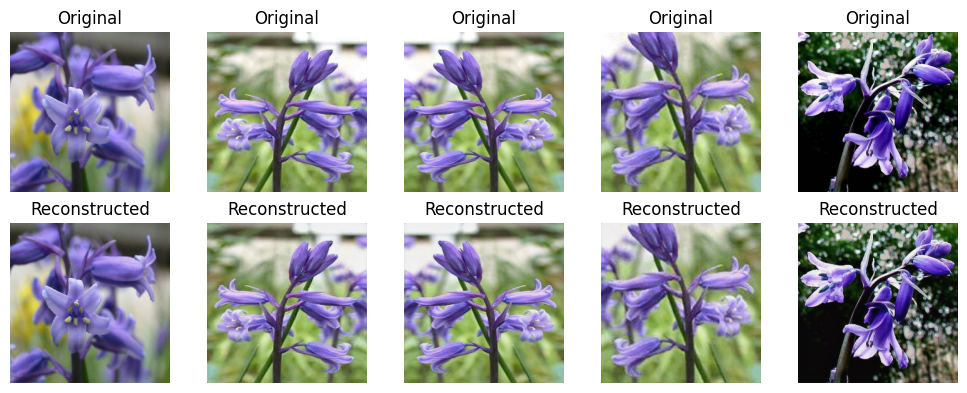

In [23]:
# Define the load_and_preprocess function
import tensorflow as tf
import numpy as np

def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    # Ensure the image is a tensor with the expected rank
    tf.ensure_shape(img, [IMG_SIZE, IMG_SIZE, 3])
    return img

# Load a few images from the dataset
sample_images = []
for i, img_file in enumerate(image_files[:5]): # Take first 5 images for evaluation
    img = load_and_preprocess(img_file)
    sample_images.append(img)

sample_images = tf.stack(sample_images, axis=0)

# Generate reconstructions
reconstructed_images = adapt_model.predict(sample_images)

# Display original and reconstructed images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(sample_images.shape[0]):
    # Original image
    plt.subplot(2, sample_images.shape[0], i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed image
    plt.subplot(2, sample_images.shape[0], i + 1 + sample_images.shape[0])
    plt.imshow(reconstructed_images[i])
    plt.title("Reconstructed")+
    
    plt.axis("off")

plt.tight_layout()
plt.show()

Reconstruct & save samples (original vs reconstruction)

In [37]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os

OUTPUT_DIR = '/content/output'  # Change as needed
sample_dir = os.path.join(OUTPUT_DIR, 'reconstructions')
os.makedirs(sample_dir, exist_ok=True)

IMG_SIZE = 256  # Adjust as required

def save_side_by_side(orig_path, recon_img, out_path):
    font_size = 24
    heading_height = 40

    # Try loading a bold font; fallback to default if not found
    try:
        font = ImageFont.truetype("arialbd.ttf", font_size)  # Bold Arial
    except:
        font = ImageFont.load_default()

    # Load and resize original and reconstructed images
    orig = Image.open(orig_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    recon = Image.fromarray((np.clip(recon_img * 255., 0, 255)).astype(np.uint8)).resize((IMG_SIZE, IMG_SIZE))

    # Create a new blank image with space for headings
    new_img = Image.new('RGB', (IMG_SIZE * 2, IMG_SIZE + heading_height), (255, 255, 255))

    draw = ImageDraw.Draw(new_img)
    # Draw bold headings
    draw.text((IMG_SIZE // 2 - 70, 5), "Original Image", fill=(0, 0, 0), font=font)
    draw.text((IMG_SIZE + IMG_SIZE // 2 - 90, 5), "Reconstructed (Compressed)", fill=(0, 0, 0), font=font)

    # Paste images under headings
    new_img.paste(orig, (0, heading_height))
    new_img.paste(recon, (IMG_SIZE, heading_height))
    new_img.save(out_path, format='JPEG', quality=95)

# Example usage for 1360 images
for i, p in enumerate(image_files[:1360]):
    img = load_and_preprocess(p)
    img_np = img.numpy()
    recon = adapt_model.base(np.expand_dims(img_np, 0), training=False).numpy()[0]
    outp = os.path.join(sample_dir, f"sample_{i:03d}.jpg")
    save_side_by_side(p, recon, outp)

print("Saved sample side-by-side images to", sample_dir)


Saved sample side-by-side images to /content/output/reconstructions


Adaptive JPEG compression function (binary search for minimal quality meeting SSIM)

In [25]:

import tensorflow as tf
def pil_image_to_tensor(pil_img):
    arr = np.asarray(pil_img).astype(np.float32)/255.0
    return tf.convert_to_tensor(arr[None,...], dtype=tf.float32)

def compress_jpeg_bytes(pil_img, quality):
    buf = io.BytesIO()
    pil_img.save(buf, format='JPEG', quality=int(quality), optimize=True)
    data = buf.getvalue()
    buf.close()
    return data

def compute_ssim_from_pil(original_pil, compressed_bytes):
    comp = Image.open(io.BytesIO(compressed_bytes)).convert('RGB').resize(original_pil.size)
    t1 = pil_image_to_tensor(original_pil)
    t2 = pil_image_to_tensor(comp)
    s = tf.image.ssim(t1, t2, max_val=1.0).numpy()[0]
    return float(s), np.asarray(comp)

def adaptive_jpeg_save(original_pil, target_ssim=TARGET_SSIM, out_path=None, qmin=10, qmax=100):
    # binary search for lowest quality achieving SSIM >= target
    best_q = None
    best_bytes = None
    lo, hi = qmin, qmax
    while lo <= hi:
        mid = (lo + hi)//2
        b = compress_jpeg_bytes(original_pil, quality=mid)
        ssim_val, _ = compute_ssim_from_pil(original_pil, b)
        if ssim_val >= target_ssim:
            best_q = mid
            best_bytes = b
            hi = mid - 1
        else:
            lo = mid + 1
    # if none found, fallback to high quality
    if best_q is None:
        best_q = qmax
        best_bytes = compress_jpeg_bytes(original_pil, quality=best_q)

    if out_path:
        with open(out_path, 'wb') as f:
            f.write(best_bytes)
    return best_q, len(best_bytes), best_bytes


compress all reconstructions adaptively and compute stats

In [26]:
#compress reconstructions adaptively, compute sizes, bpp, and summary CSV
import csv
recon_out_dir = os.path.join(OUTPUT_DIR, 'adaptive_jpeg')
os.makedirs(recon_out_dir, exist_ok=True)
rows = []
for i, p in enumerate(tqdm(image_files)):
    # original image resized to IMG_SIZE
    orig = Image.open(p).convert('RGB').resize((IMG_SIZE,IMG_SIZE))
    # get reconstruction from model
    img_tf = load_and_preprocess(p).numpy()
    recon = adapt_model.base(np.expand_dims(img_tf,0), training=False).numpy()[0]
    recon_pil = Image.fromarray((np.clip(recon*255.,0,255)).astype(np.uint8))
    # run adaptive compression
    fname = os.path.basename(p)
    outpath = os.path.join(recon_out_dir, fname.rsplit('.',1)[0] + '.jpg')
    q, size_bytes, _ = adaptive_jpeg_save(recon_pil, target_ssim=TARGET_SSIM, out_path=outpath)
    w,h = IMG_SIZE, IMG_SIZE
    bpp = (size_bytes*8) / (w*h)
    rows.append((p, outpath, q, size_bytes, bpp))
# write CSV
csv_path = os.path.join(OUTPUT_DIR, 'compression_stats.csv')
with open(csv_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['orig_path','recon_jpeg_path','quality','size_bytes','bpp'])
    writer.writerows(rows)
print("Saved compression stats to", csv_path)


100%|██████████| 1360/1360 [05:11<00:00,  4.37it/s]

Saved compression stats to /content/output/compression_stats.csv


show summary statistics

In [27]:

import pandas as pd
df = pd.read_csv(os.path.join(OUTPUT_DIR,'compression_stats.csv'))
print("Count:", len(df))
print("Mean size (KB):", df['size_bytes'].mean()/1024)
print("Median size (KB):", df['size_bytes'].median()/1024)
print("Mean bpp:", df['bpp'].mean())
print("Quality percentiles:\n", df['quality'].quantile([0.25,0.5,0.75,0.95]))
# show top 5 largest files
df.sort_values('size_bytes', ascending=False).head(5)


Count: 1360
Mean size (KB): 54.94854377297794
Median size (KB): 54.62255859375
Mean bpp: 6.868567971622243
Quality percentiles:
 0.25    100.0
0.50    100.0
0.75    100.0
0.95    100.0
Name: quality, dtype: float64


,orig_path,recon_jpeg_path,quality,size_bytes,bpp
201,/content/dataset/17FlowerOxfordDataset/cowslip...,/content/output/adaptive_jpeg/image_1082.jpg,100,79242,9.673096
1198,/content/dataset/17FlowerOxfordDataset/tiger l...,/content/output/adaptive_jpeg/image_0559.jpg,100,77152,9.417969
319,/content/dataset/17FlowerOxfordDataset/crocus/...,/content/output/adaptive_jpeg/image_0400.jpg,100,76889,9.385864
194,/content/dataset/17FlowerOxfordDataset/cowslip...,/content/output/adaptive_jpeg/image_1075.jpg,100,76090,9.288330
305,/content/dataset/17FlowerOxfordDataset/crocus/...,/content/output/adaptive_jpeg/image_0386.jpg,100,76076,9.286621


In [40]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Paths
# original_dir = "/content/dataset" # No longer needed as we iterate through image_files
recon_dir = "/content/output/adaptive_jpeg" # Updated to point to the directory with reconstructed JPEGs

# Image size
IMG_SIZE = 256  # adjust to your project - set to 256 based on notebook constant

# Function to load and preprocess image
def load_image(path):
    img = Image.open(path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
    return np.array(img) / 255.0  # normalize to [0,1]

# Lists to store metrics
psnr_list = []
ssim_list = []
mse_list = []

# Use the already defined image_files list which contains paths to all images
# We will match original image files with their corresponding reconstructed JPEGs
# based on the filename.

# Ensure that the number of original files we process matches the number of reconstructed files
# Find corresponding reconstructed files in the adaptive_jpeg directory
recon_image_files = [os.path.join(recon_dir, os.path.basename(f).rsplit('.', 1)[0] + '.jpg') for f in image_files]

# Filter out original files that do not have a corresponding reconstructed file
# This is important if there was an issue during the reconstruction or adaptive compression step
valid_image_files = [f for i, f in enumerate(image_files) if os.path.exists(recon_image_files[i])]
valid_recon_files = [f for f in recon_image_files if os.path.exists(f)]

print(f"Evaluating metrics for {len(valid_image_files)} images.")

for orig_path, recon_path in zip(valid_image_files, valid_recon_files):
    try:
        orig_img = load_image(orig_path)
        recon_img = load_image(recon_path)

        # MSE
        mse_val = np.mean((orig_img - recon_img) ** 2)

        # PSNR
        psnr_val = psnr(orig_img, recon_img, data_range=1.0)

        # SSIM (per channel averaged)
        ssim_val = ssim(orig_img, recon_img, data_range=1.0, channel_axis=-1) # Use channel_axis for newer skimage versions

        mse_list.append(mse_val)
        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
    except Exception as e:
        print(f"Skipping {orig_path} due to error: {e}")


# Compute average metrics
if mse_list: # Check if the list is not empty
    print(f"Average MSE: {np.mean(mse_list):.6f}")
    print(f"Average PSNR: {np.mean(psnr_list):.2f} dB")
    print(f"Average SSIM: {np.mean(ssim_list):.4f}")
else:
    print("No valid images were processed to compute metrics.")

Evaluating metrics for 1360 images.
Average MSE: 0.000701
Average PSNR: 32.27 dB
Average SSIM: 0.9400


### Visualize Evaluation Metrics

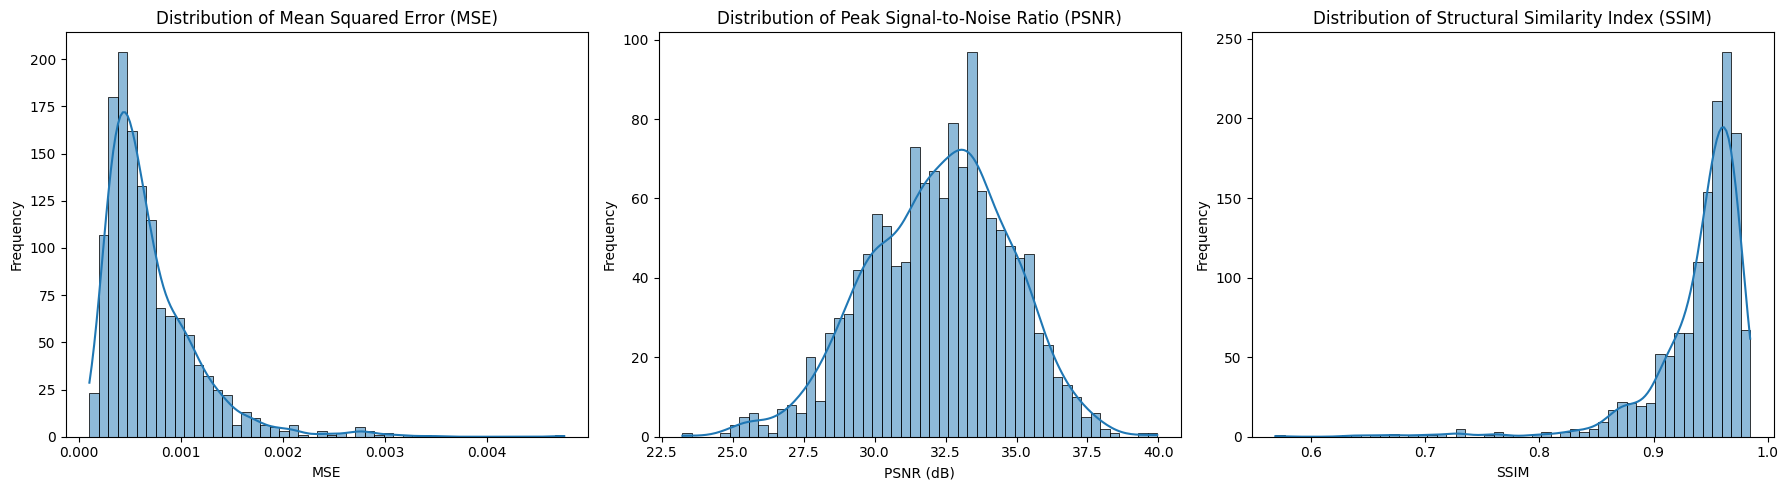

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot MSE distribution
sns.histplot(mse_list, bins=50, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Frequency')

# Plot PSNR distribution
sns.histplot(psnr_list, bins=50, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Peak Signal-to-Noise Ratio (PSNR)')
axes[1].set_xlabel('PSNR (dB)')
axes[1].set_ylabel('Frequency')

# Plot SSIM distribution
sns.histplot(ssim_list, bins=50, kde=True, ax=axes[2])
axes[2].set_title('Distribution of Structural Similarity Index (SSIM)')
axes[2].set_xlabel('SSIM')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Save Evaluation Results

In [42]:
import pandas as pd
import os

# Create a DataFrame from the lists
eval_df = pd.DataFrame({
    'original_path': valid_image_files,
    'reconstructed_jpeg_path': valid_recon_files,
    'mse': mse_list,
    'psnr': psnr_list,
    'ssim': ssim_list
})

# Define the output path for the evaluation results CSV
eval_csv_path = os.path.join(OUTPUT_DIR, 'evaluation_metrics.csv')

# Save the DataFrame to a CSV file
eval_df.to_csv(eval_csv_path, index=False)

print(f"Evaluation metrics saved to: {eval_csv_path}")

# Display the first few rows of the evaluation DataFrame
print("\nSample of evaluation metrics:")
display(eval_df.head())

Evaluation metrics saved to: /content/output/evaluation_metrics.csv

Sample of evaluation metrics:


,original_path,reconstructed_jpeg_path,mse,psnr,ssim
0,/content/dataset/17FlowerOxfordDataset/bluebel...,/content/output/adaptive_jpeg/image_0241.jpg,0.000353,34.527917,0.972966
1,/content/dataset/17FlowerOxfordDataset/bluebel...,/content/output/adaptive_jpeg/image_0242.jpg,0.000544,32.645259,0.972755
2,/content/dataset/17FlowerOxfordDataset/bluebel...,/content/output/adaptive_jpeg/image_0243.jpg,0.000644,31.912538,0.967447
3,/content/dataset/17FlowerOxfordDataset/bluebel...,/content/output/adaptive_jpeg/image_0244.jpg,0.000366,34.360630,0.979524
4,/content/dataset/17FlowerOxfordDataset/bluebel...,/content/output/adaptive_jpeg/image_0245.jpg,0.001203,29.197696,0.859616


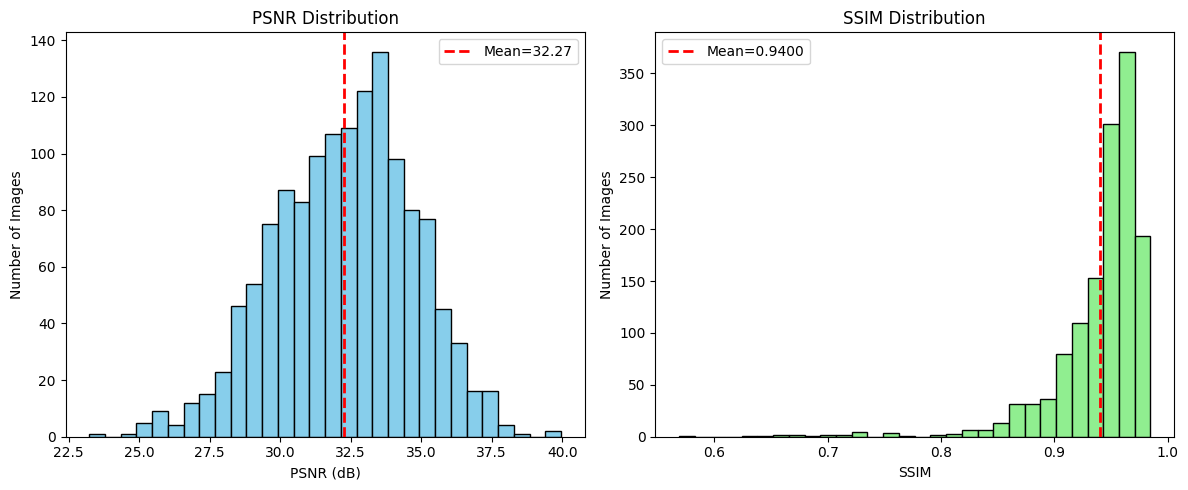

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming psnr_list and ssim_list are already computed from your previous code

# Convert to numpy arrays for convenience
psnr_array = np.array(psnr_list)
ssim_array = np.array(ssim_list)

# Create figure
plt.figure(figsize=(12,5))

# PSNR histogram
plt.subplot(1, 2, 1)
plt.hist(psnr_array, bins=30, color='skyblue', edgecolor='black')
plt.title('PSNR Distribution')
plt.xlabel('PSNR (dB)')
plt.ylabel('Number of Images')
plt.axvline(np.mean(psnr_array), color='red', linestyle='dashed', linewidth=2, label=f'Mean={np.mean(psnr_array):.2f}')
plt.legend()

# SSIM histogram
plt.subplot(1, 2, 2)
plt.hist(ssim_array, bins=30, color='lightgreen', edgecolor='black')
plt.title('SSIM Distribution')
plt.xlabel('SSIM')
plt.ylabel('Number of Images')
plt.axvline(np.mean(ssim_array), color='red', linestyle='dashed', linewidth=2, label=f'Mean={np.mean(ssim_array):.4f}')
plt.legend()

plt.tight_layout()
plt.show()


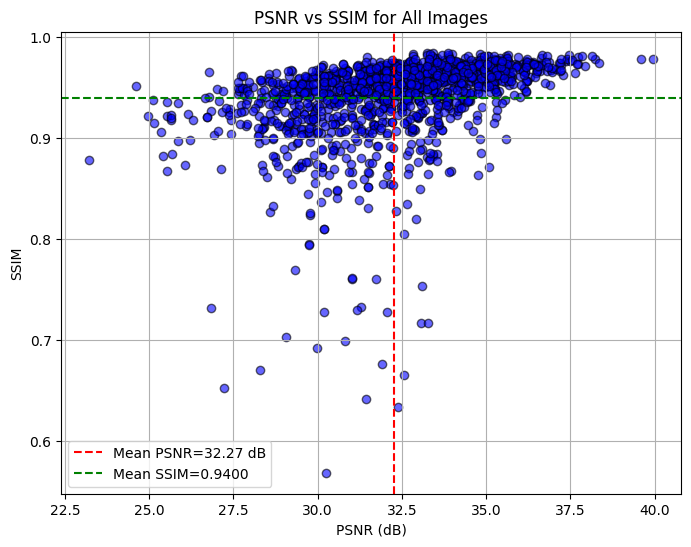

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming psnr_list and ssim_list are already computed
psnr_array = np.array(psnr_list)
ssim_array = np.array(ssim_list)

plt.figure(figsize=(8,6))
plt.scatter(psnr_array, ssim_array, c='blue', alpha=0.6, edgecolor='k')
plt.xlabel('PSNR (dB)')
plt.ylabel('SSIM')
plt.title('PSNR vs SSIM for All Images')
plt.grid(True)

# Optional: plot mean lines
plt.axvline(np.mean(psnr_array), color='red', linestyle='dashed', label=f'Mean PSNR={np.mean(psnr_array):.2f} dB')
plt.axhline(np.mean(ssim_array), color='green', linestyle='dashed', label=f'Mean SSIM={np.mean(ssim_array):.4f}')
plt.legend()

plt.show()


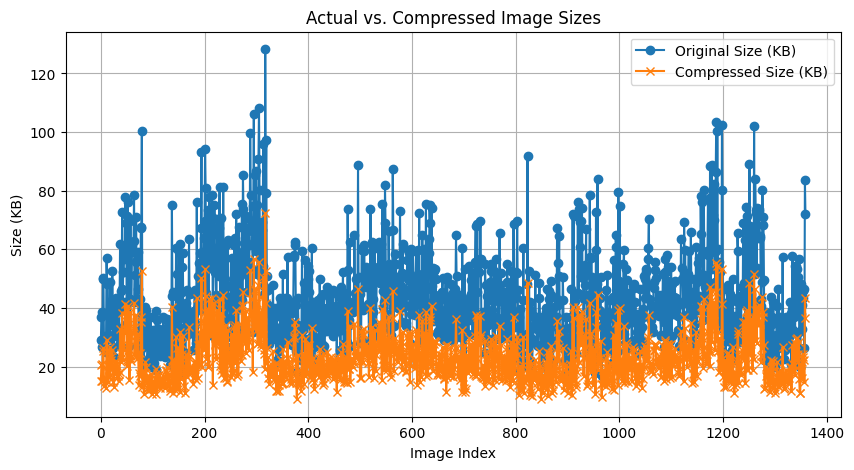

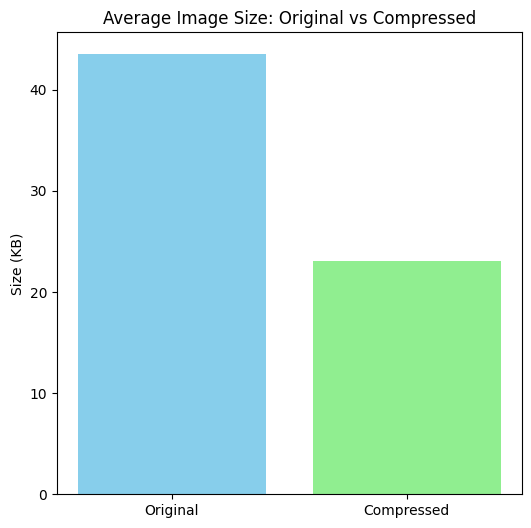

Average Original Size: 43.51 KB
Average Compressed Size: 23.08 KB
Compression Ratio: 1.89x


In [28]:
# Required Libraries
import os
import cv2
import matplotlib.pyplot as plt

# Directory containing original images (updated to match image_files structure)
# We will iterate through the image_files list directly
# image_dir = '/content/dataset/'  # Change to your folder path
compressed_dir = '/content/compressed_images/'

os.makedirs(compressed_dir, exist_ok=True)

# Lists to store sizes
original_sizes = []
compressed_sizes = []
image_basenames = [] # To store filenames for compressed paths

# Compression quality (1-100)
compression_quality = 30  # Lower → higher compression

# Process images from the image_files list
for filepath in image_files:
    # Original size in KB
    original_size = os.path.getsize(filepath) / 1024
    original_sizes.append(original_size)

    # Read image
    # Use cv2.IMREAD_COLOR to ensure 3 channels, even if the image is grayscale
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)

    if img is None:
        print(f"Warning: Could not read image file: {filepath}. Skipping.")
        continue

    # Get the filename to use for the compressed path
    filename = os.path.basename(filepath)
    image_basenames.append(filename)

    # Compressed image path
    compressed_path = os.path.join(compressed_dir, filename)

    # Save compressed image
    # Ensure the image is not None before saving
    try:
        cv2.imwrite(compressed_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), compression_quality])
    except Exception as e:
        print(f"Error saving compressed image {compressed_path}: {e}. Skipping.")
        continue


    # Compressed size in KB
    compressed_size = os.path.getsize(compressed_path) / 1024
    compressed_sizes.append(compressed_size)

# Check if any images were processed before plotting and calculating averages
if original_sizes and compressed_sizes:
    # Plot actual vs. compressed sizes
    plt.figure(figsize=(10,5))
    plt.plot(original_sizes, label='Original Size (KB)', marker='o')
    plt.plot(compressed_sizes, label='Compressed Size (KB)', marker='x')
    plt.title('Actual vs. Compressed Image Sizes')
    plt.xlabel('Image Index')
    plt.ylabel('Size (KB)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Bar plot for comparison of average sizes
    plt.figure(figsize=(6,6))
    plt.bar(['Original', 'Compressed'], [sum(original_sizes)/len(original_sizes),
                                        sum(compressed_sizes)/len(compressed_sizes)],
            color=['skyblue', 'lightgreen'])
    plt.title('Average Image Size: Original vs Compressed')
    plt.ylabel('Size (KB)')
    plt.show()

    # Print summary statistics
    print(f"Average Original Size: {sum(original_sizes)/len(original_sizes):.2f} KB")
    print(f"Average Compressed Size: {sum(compressed_sizes)/len(compressed_sizes):.2f} KB")
    print(f"Compression Ratio: {sum(original_sizes)/sum(compressed_sizes):.2f}x")
else:
    print("No valid images were found or processed to generate statistics.")